In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from transformers import DataCollatorWithPadding

from transformers import  BertModel, BertTokenizerFast, BertConfig
from transformers import RobertaModel, RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

import torch.nn as nn
import torch

2025-06-08 16:07:24.644467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749398844.810565      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749398844.859560      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Importing Dataset

In [4]:
df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Exploring Dataset

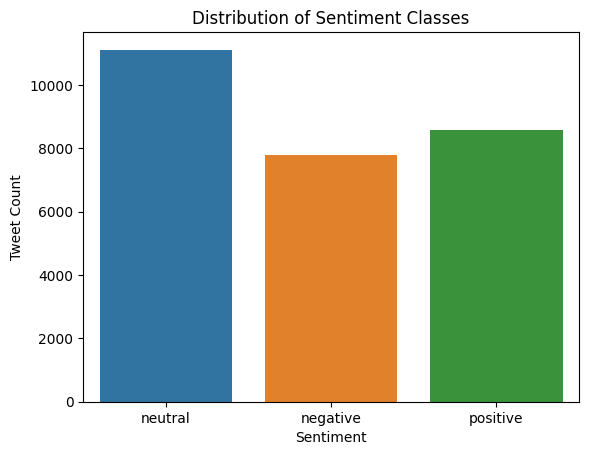

In [5]:
sns.countplot(data=df, x='sentiment')
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()


Shows a pretty even distribution of positive and negative + a lot of neutral sentiment tweets.

In [6]:
df.sample(5)[['text', 'selected_text', 'sentiment']]

,text,selected_text,sentiment
4699,apple fritters are like the perfect after food...,the perfect after food...,positive
7962,"Oh PW, you done me wrong. The signing time in ...",wrong.,negative
19782,last day of volleyball miss everyone already. ...,last day of volleyball miss everyone already. ...,neutral
3747,"Prayin for dad in Wellington, FL http://loopt...",Prayin,positive
12174,I`m no longer a sophomore. Junior year is bri...,I`m no longer a sophomore. Junior year is bri...,neutral


Basic Span Checking:

In [7]:
(df['text'].str.strip() == df['selected_text'].str.strip()).mean()

0.44619919216913506

So, almost 44% of the time, the whole text = selected Text.

Full Picture of The Data:

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

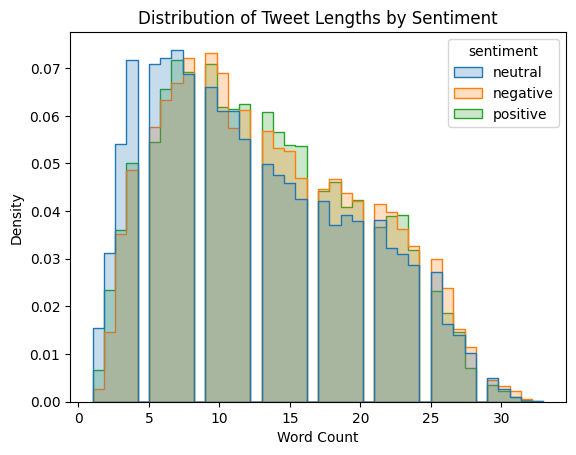

In [8]:
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df, x='text_len', bins=40, hue='sentiment', element='step', stat='density', common_norm=False)
plt.title("Distribution of Tweet Lengths by Sentiment")
plt.xlabel("Word Count")
plt.show()

Showing not much of a relation between length of tweet and sentiment

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

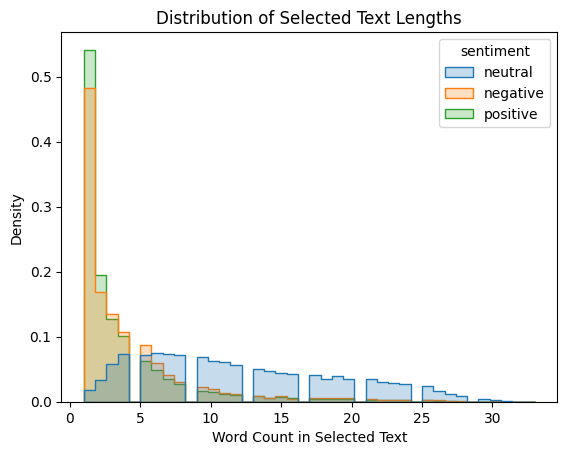

In [9]:
df['sel_len'] = df['selected_text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df, x='sel_len', bins=40, hue='sentiment', element='step', stat='density', common_norm=False)
plt.title("Distribution of Selected Text Lengths")
plt.xlabel("Word Count in Selected Text")
plt.show()

Around 5 words of selected text are required to make the determination of whether this text carries a positive or negative sentiment. So, the determination is looking for a select few patterns and keywords to make this determination

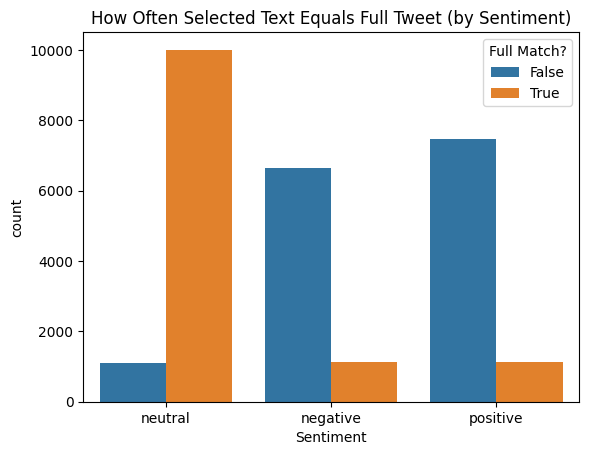

In [11]:
df['is_full_text'] = (df['text'].str.strip() == df['selected_text'].str.strip())
sns.countplot(data=df, x='sentiment', hue='is_full_text')
plt.title("How Often Selected Text Equals Full Tweet (by Sentiment)")
plt.xlabel("Sentiment")
plt.legend(title="Full Match?")
plt.show()


Further confirms our belief that a short span of selected text is required to make the determination of sentiment being positive or negative.

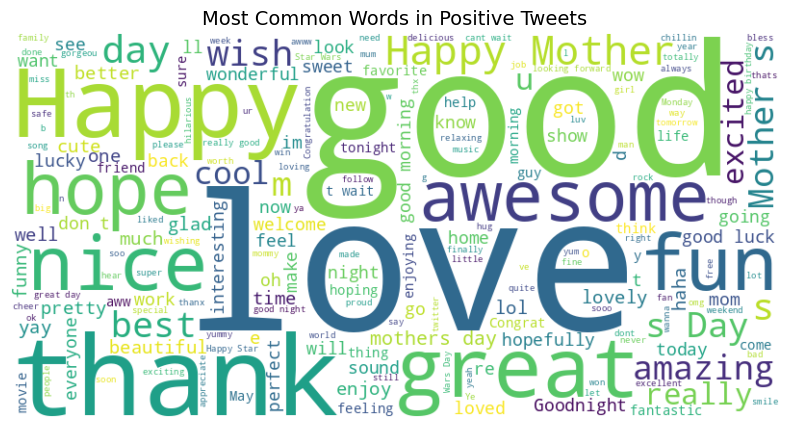

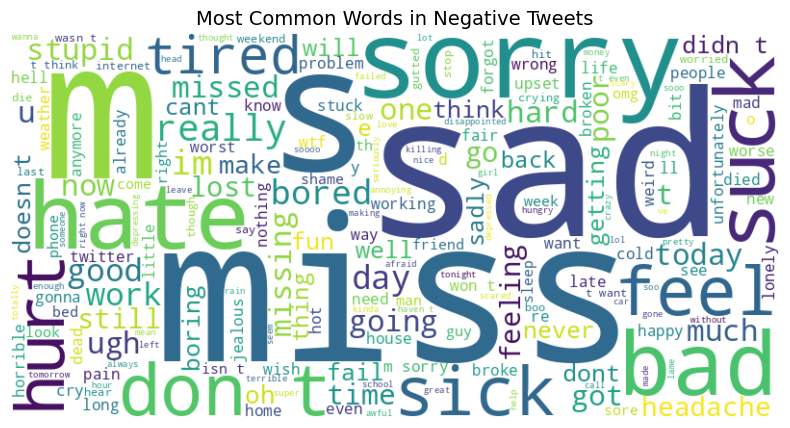

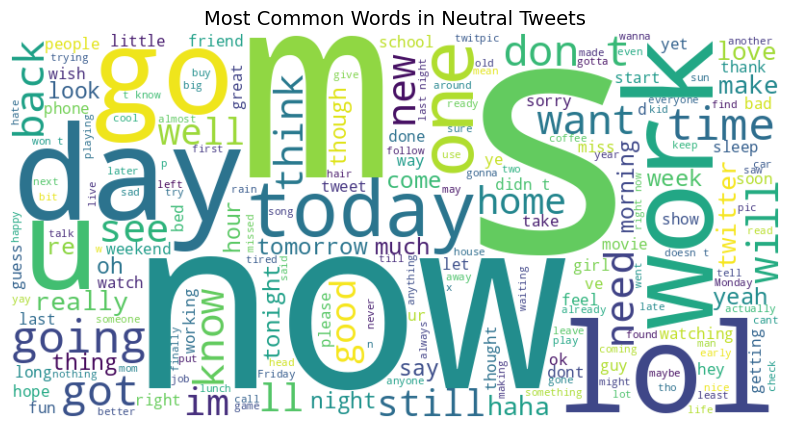

In [12]:
from collections import Counter
from wordcloud import WordCloud

def plot_wordcloud(sentiment):
    words = df[df['sentiment'] == sentiment]['selected_text'].str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Common Words in {sentiment.capitalize()} Tweets", fontsize=14)
    plt.show()

plot_wordcloud("positive")
plot_wordcloud("negative")
plot_wordcloud("neutral")


Looks like we can see a few of the most commonly occuring words that make the determination of whether the tweet sentiment is positive or negative.

In [13]:
#Finds the Char start and end indices of selected_index inside text
def find_substring(text,sub):
    start_idx = text.lower().find(sub.lower())
    if start_idx == -1:
        return None, None
    end_idx = start_idx + len(sub)
    return start_idx, end_idx

In [14]:
#Create Input Format, give input IDS + map each token to its start,endchar range in tweet
def prepare_input(text, sentiment):
    encoded = tokenizer.encode_plus(
        sentiment, text,
        add_special_tokens=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
        truncation=True,
        return_token_type_ids=False
    )
    return encoded


In [15]:
def char_targets_to_token_indices(text, selected_text, offsets):
    start_char, end_char = find_substring(text, selected_text)

    if start_char is None:
        return 0, 0

    start_token = None
    end_token = None

    for i, (offset_start, offset_end) in enumerate(offsets):
        if offset_start <= start_char < offset_end:
            start_token = i
        if offset_start < end_char <= offset_end:
            end_token = i
            break

    return start_token, end_token

def encode_data(df):
    input_ids_list = []
    attention_masks = []
    start_positions = []
    end_positions = []
    sentiment_labels = []

    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}

    for row in df.itertuples(index=False):
        text = row.text
        selected = row.selected_text
        sentiment = row.sentiment

        encoded = prepare_input(text, sentiment)
        offsets = encoded['offset_mapping']
        input_ids = torch.tensor(encoded['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor([1] * len(input_ids), dtype=torch.long)

        start_idx, end_idx = char_targets_to_token_indices(text, selected, offsets)

        input_ids_list.append(input_ids)
        attention_masks.append(attention_mask)
        start_positions.append(start_idx)
        end_positions.append(end_idx)
        sentiment_labels.append(sentiment_map[sentiment])

    return TweetDataset(input_ids_list, attention_masks, start_positions, end_positions, sentiment_labels)



    

Up ABove are all the helper methods we'd be using to break down the string from it's characters to rebuild the tokens.
Now we create model classes.

In [16]:
class TweetSentimentExtractor(nn.Module):
    def __init__(self):
        super(TweetSentimentExtractor, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.span_fc = nn.Linear(self.roberta.config.hidden_size, 2)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.last_hidden_state[:, 0]

        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)

        span_logits = self.span_fc(sequence_output)
        start_logits, end_logits = span_logits.split(1, dim=2)
        sentiment_logits = self.classifier(pooled_output)

        return start_logits.squeeze(-1), end_logits.squeeze(-1), sentiment_logits


In [17]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class TweetDataset(Dataset):
    def __init__(self, input_ids, attention_masks, start_positions, end_positions, sentiment_labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.start_positions = start_positions
        self.end_positions = end_positions
        self.sentiment_labels = sentiment_labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'start_positions': self.start_positions[idx],
            'end_positions': self.end_positions[idx],
            'sentiment_label': self.sentiment_labels[idx]
        }


Prerpocessing Dataset for Model Training/Testing

In [18]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    start_positions = [item['start_positions'] for item in batch]
    end_positions = [item['end_positions'] for item in batch]
    sentiment_labels = [item['sentiment_label'] for item in batch]  # <- this must be included

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'start_positions': torch.tensor(start_positions),
        'end_positions': torch.tensor(end_positions),
        'sentiment_labels': torch.tensor(sentiment_labels)
    }

In [19]:
from sklearn.model_selection import train_test_split

df = df.dropna(subset=['text', 'selected_text', 'sentiment']).reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['sentiment'], random_state=42)

train_dataset = encode_data(train_df)
val_dataset = encode_data(val_df)


Dataset & Dataloader

In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

Instantiating Model

In [21]:
model = TweetSentimentExtractor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Making Model

In [22]:
from tqdm import tqdm

best_val_loss = float('inf')
patience = 2
patience_counter = 0

loss_fn_span = nn.CrossEntropyLoss()
loss_fn_sentiment = nn.CrossEntropyLoss()

def weighted_loss_fn(start_logits, end_logits, start_positions, end_positions, start_weight=0.7):
    loss_start = loss_fn_span(start_logits, start_positions)
    loss_end = loss_fn_span(end_logits, end_positions)
    return start_weight * loss_start + (1 - start_weight) * loss_end

EPOCHS = 6

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        sentiment_labels = batch['sentiment_labels'].to(device)

        optimizer.zero_grad()
        start_logits, end_logits, sentiment_logits = model(input_ids=input_ids, attention_mask=attention_mask)

        loss_span = weighted_loss_fn(start_logits, end_logits, start_positions, end_positions, start_weight=0.7)
        loss_sentiment = loss_fn_sentiment(sentiment_logits, sentiment_labels)
        loss = loss_span + loss_sentiment  # combine losses

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(train_loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Avg Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            sentiment_labels = batch['sentiment_labels'].to(device)

            start_logits, end_logits, sentiment_logits = model(input_ids=input_ids, attention_mask=attention_mask)

            loss_span = weighted_loss_fn(start_logits, end_logits, start_positions, end_positions)
            loss_sentiment = loss_fn_sentiment(sentiment_logits, sentiment_labels)
            loss = loss_span + loss_sentiment

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} - Avg Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Best model saved")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break


Epoch 1 [Train]: 100%|██████████| 1546/1546 [03:49<00:00,  6.72it/s, train_loss=0.988]


Epoch 1 - Avg Train Loss: 1.3215
Epoch 1 - Avg Val Loss: 0.9328
✅ Best model saved


Epoch 2 [Train]: 100%|██████████| 1546/1546 [03:56<00:00,  6.52it/s, train_loss=0.467]


Epoch 2 - Avg Train Loss: 0.8954
Epoch 2 - Avg Val Loss: 0.8579
✅ Best model saved


Epoch 3 [Train]: 100%|██████████| 1546/1546 [03:56<00:00,  6.53it/s, train_loss=0.975]


Epoch 3 - Avg Train Loss: 0.8111
Epoch 3 - Avg Val Loss: 0.8419
✅ Best model saved


Epoch 4 [Train]: 100%|██████████| 1546/1546 [03:56<00:00,  6.53it/s, train_loss=0.632]


Epoch 4 - Avg Train Loss: 0.7386
Epoch 4 - Avg Val Loss: 0.8538
⚠️ No improvement. Patience: 1/2


Epoch 5 [Train]: 100%|██████████| 1546/1546 [03:56<00:00,  6.52it/s, train_loss=0.881]


Epoch 5 - Avg Train Loss: 0.6733
Epoch 5 - Avg Val Loss: 0.8939
⚠️ No improvement. Patience: 2/2
⛔ Early stopping triggered.


Model Prediction Analysis

In [23]:
def predict_selected_text(model, tokenizer, text, sentiment, device):
    model.eval()
    inputs = tokenizer.encode_plus(
        sentiment, text,
        add_special_tokens=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    offsets = inputs['offset_mapping'][0].tolist()

    with torch.no_grad():
        start_logits, end_logits, sentiment_logits = model(input_ids, attention_mask)
        start_prob = torch.softmax(start_logits, dim=1).cpu().numpy()
        end_prob = torch.softmax(end_logits, dim=1).cpu().numpy()
        sentiment_pred = torch.argmax(sentiment_logits, dim=1).item()

    start_idx = start_prob.argmax(1)[0]
    end_idx = end_prob.argmax(1)[0]
    if start_idx > end_idx:
        end_idx = start_idx

    selected_text = text[offsets[start_idx][0]: offsets[end_idx][1]]

    id2sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return selected_text.strip(), id2sentiment[sentiment_pred]


Jaccard Test on Model

In [24]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    if not a and not b:
        return 1.0
    return len(a & b) / len(a | b)

model.eval()
scores = []
N = 20  # You can increase this later

for i in range(N):
    text = df.loc[i, 'text']
    true_sel = df.loc[i, 'selected_text']
    true_sentiment = df.loc[i, 'sentiment']

    pred_sel, pred_sentiment = predict_selected_text(model, tokenizer, text, true_sentiment, device)
    score = jaccard(pred_sel, true_sel)
    scores.append(score)

    print(f"\nTweet:            {text}")
    print(f"True Sentiment:   {true_sentiment}")
    print(f"Pred Sentiment:   {pred_sentiment}")
    print(f"True Span:        {true_sel}")
    print(f"Predicted Span:   {pred_sel}")
    print(f"Jaccard Score:    {score:.3f}")

print(f"\n✅ Average Jaccard over {N} samples: {sum(scores)/len(scores):.4f}")



Tweet:             I`d have responded, if I were going
True Sentiment:   neutral
Pred Sentiment:   neutral
True Span:        I`d have responded, if I were going
Predicted Span:   I`d have responded, if I were going
Jaccard Score:    1.000

Tweet:             Sooo SAD I will miss you here in San Diego!!!
True Sentiment:   negative
Pred Sentiment:   negative
True Span:        Sooo SAD
Predicted Span:   Sooo SAD
Jaccard Score:    1.000

Tweet:            my boss is bullying me...
True Sentiment:   negative
Pred Sentiment:   negative
True Span:        bullying me
Predicted Span:   bullying me...
Jaccard Score:    0.333

Tweet:             what interview! leave me alone
True Sentiment:   negative
Pred Sentiment:   negative
True Span:        leave me alone
Predicted Span:   leave me alone
Jaccard Score:    1.000

Tweet:             Sons of ****, why couldn`t they put them on the releases we already bought
True Sentiment:   negative
Pred Sentiment:   negative
True Span:        Sons of ****,


Saving State

In [25]:
# Save
torch.save(model.state_dict(), "tweet_sentiment_model.pt")

# Reload
model = TweetSentimentExtractor()
model.load_state_dict(torch.load("tweet_sentiment_model.pt", map_location=device))
model.to(device)
model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TweetSentimentExtractor(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay